In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import string
import random

In [392]:
raw_data = pd.read_csv('../Data/Detect AI Generated Text/train_essays.csv')
raw_data['text_len'] = raw_data['text'].apply(lambda x: len(x.split()))

In [393]:
raw_data.columns

Index(['id', 'prompt_id', 'text', 'generated', 'text_len'], dtype='object')

In [394]:
raw_data.head(2)

,id,prompt_id,text,generated,text_len
0,0059830c,0,Cars. Cars have been around since they became ...,0,584
1,005db917,0,Transportation is a large necessity in most co...,0,462


In [395]:
raw_data['generated'].value_counts()

0    1375
1       3
Name: generated, dtype: int64

In [396]:
conn = sqlite3.connect('../Data/Detect AI Generated Text/generated_essays.db')

c = conn.cursor()

c.execute(''' SELECT * FROM essays ''')

# Create a dataframe from the generated text

generated_text_df = pd.DataFrame(c.fetchall(), columns=['id', 'prompt_id', 'text', 'generated', 'model'])

conn.close()



In [397]:
generated_text_df.value_counts('model')

model
catPPT     505
dolphin    490
mistral    470
dtype: int64

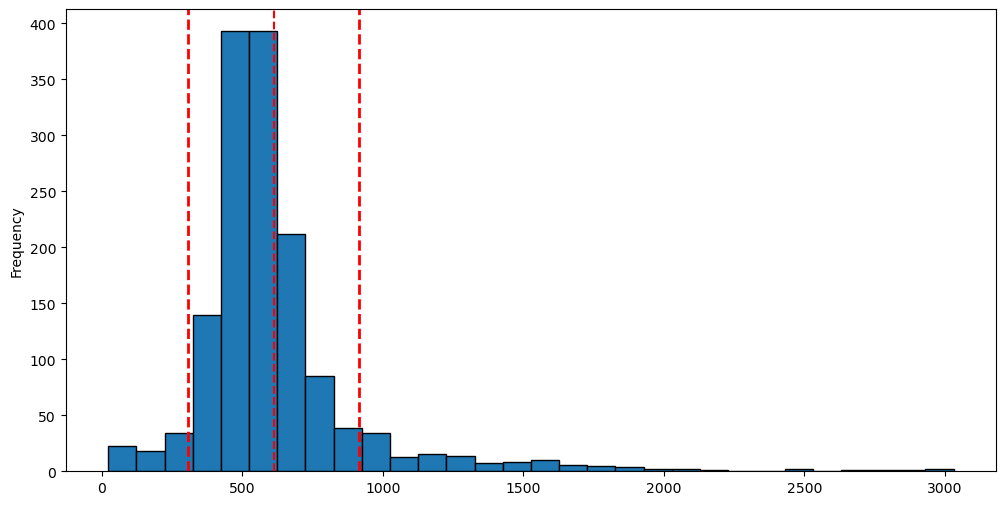

In [398]:
generated_text_df['text_len'] = generated_text_df['text'].apply(lambda x: len(x.split()))
generated_text_df['text_len'].plot(kind='hist', bins=30, figsize=(12,6), edgecolor='black', linewidth=1.0)

plt.axvline(generated_text_df['text_len'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(generated_text_df['text_len'].mean() + generated_text_df['text_len'].std(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(generated_text_df['text_len'].mean()-generated_text_df['text_len'].std(), color='r', linestyle='dashed', linewidth=2)

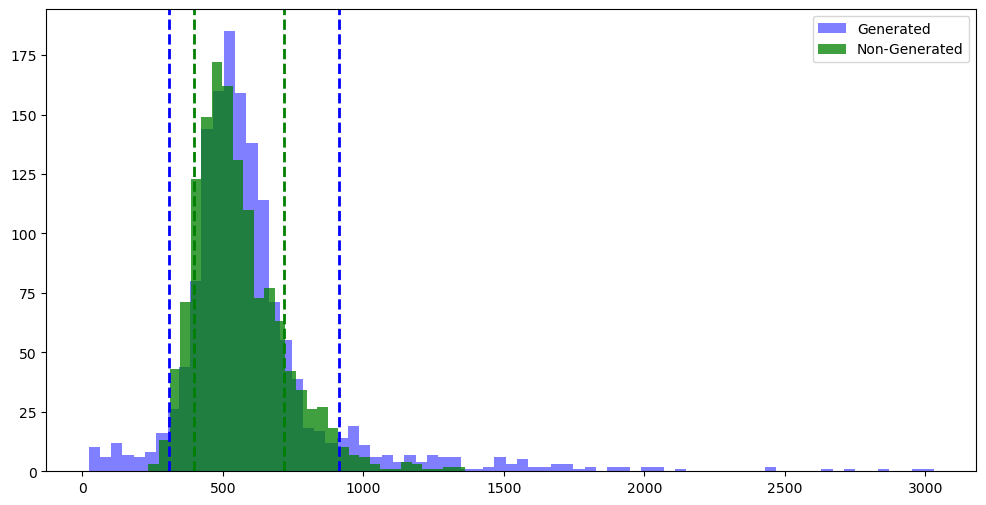

In [399]:
plt.figure(figsize=(12,6))
plt.hist(generated_text_df['text_len'], bins=75,  alpha=0.5, label='Generated', color='blue')
plt.hist(raw_data['text_len'], bins=30, alpha=0.75, label='Non-Generated', color='green')
plt.axvline(generated_text_df['text_len'].mean() + generated_text_df['text_len'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(raw_data['text_len'].mean() + raw_data['text_len'].std(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(generated_text_df['text_len'].mean()-generated_text_df['text_len'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(raw_data['text_len'].mean()-raw_data['text_len'].std(), color='green', linestyle='dashed', linewidth=2)
plt.legend()
plt.show()

In [400]:
generated_text_df[generated_text_df['text_len'] > 2000]

,id,prompt_id,text,generated,model,text_len
256,xu4uquwf,1,Advantages of Limiting Car Usage\n\nThe advant...,1,mistral,2865
267,bjgohkyk,1,"In a U.K. town, car-free streets are being wel...",1,mistral,2033
325,bakrk0pc,0,Car Sharing Spreads to Europe by James Kanter\...,1,catPPT,2972
614,ouzkrsau,1,"In his essay, Judge Richard A. Posner makes se...",1,catPPT,2455
678,2wf3e44f,1,In response to this debate on the Electoral Co...,1,catPPT,2634
697,5n4j7q6b,1,\nIn this debate over whether or not the Unite...,1,catPPT,3031
699,gl6cdl4x,1,"To Whom It May Concern,\nThe Electoral College...",1,catPPT,2735
953,1txhjz4l,0,Advantages of Limiting Car Usage\n\nThe advant...,1,catPPT,2146
1177,4486hy3w,0,"In his essay, Judge Richard A. Posner makes se...",1,dolphin,2455
1239,khp7el1b,0,"In a U.K. town, car-free streets are being wel...",1,catPPT,2033


In [401]:
long_text = generated_text_df[generated_text_df['text_len'] > 2000]

print(long_text['text'].values[0])

Advantages of Limiting Car Usage

The advantages of limiting car usage are multiple, both for individuals and societies in general. This can be inferred from various passages presented here: one is about Vauban, a German suburb where automobile use has been greatly reduced; the second passage relates to a day when Parisians were prohibited by law to drive their cars due to hazardous smog pollution, and the third is set in Bogota, Colombia, a city where an annual event bans vehicles for a day in an attempt to promote alternative transportation methods. The fourth and fifth passages are more global in focus—the former examines the possible end of car culture in the U.S., and the latter provides data about peak driving levels reached in different countries.

From the perspective of individuals, reducing automobile use can result in significant positive impacts. This is most vividly illustrated in Vauban where residents, especially parents like Heidrun Walter who are interviewed, attest th

In [402]:
# Find each essay that has '#' in it
gen_hash = generated_text_df[generated_text_df['text'].str.contains('#')]
gen_hash.value_counts('model')

model
dolphin    20
catPPT      3
dtype: int64

In [403]:
raw_hash = raw_data[raw_data['text'].str.contains('#')]
raw_hash.value_counts('prompt_id')

Series([], dtype: int64)

No student essays have # marks to indicate paragraph. Removing this from all generated.

Some generated essays have multiple essays, splitting these into multiple.

In [404]:
# Remove the '#' from the text
for i, row in generated_text_df.iterrows():
    if '#' in row['text']:
        # Divide the source text into paragraphs by splitting on the string '#'
        paragraphs = row['text'].split('#')

        # Remove any empty paragraphs
        paragraphs = [paragraph for paragraph in paragraphs if paragraph != '']

        # Remove any leading or trailing whitespace from each paragraph
        paragraphs = [paragraph.strip() for paragraph in paragraphs]
        paragraphs = [paragraph[1:] if paragraph.startswith(' ') else paragraph for paragraph in paragraphs]

        # Combine the paragraphs back into a single string, separated by '\n\n'
        paragraphs = r'\n\n'.join(paragraphs)

        # Remove the first '\n\n' from the string
        if paragraphs.startswith(r'\n\n'):
            paragraphs = paragraphs[2:]

        # Replace the original text with the new text
        generated_text_df.loc[i, 'text'] = paragraphs
generated_text_df.reset_index(drop=True, inplace=True)

In [405]:
rem_lines = ['Reference', 'Cite', 'Bibliography', 'Citation', 'Sources', 'Source(s)', 'Excerpt from', 'Writing Process', 'Note:']
rem_words = ['Essay Sample', 'Introduction:', 'Introduction', 'Explanation and Essay:', 'Explanation and Analysis:' 'Discussion:', 'Discussion', 'Informational Essay', 'Essay', 'Conclusion:', 'Exploratory Essay', '[/INST]']
rem_paragraphs = ['Introduction', 'Conclusion:', 'Letter:', 'Subject:','[Address]','[City, State ZIP Code]', '[Date]']
rem_intros = ['Explanatory : ', 'Explanatory:', 'Explanatory Essay:', 'Explanatory Essay :', 'Response:', 'Response :', 'Response', ': ', r'Advantages of Limiting Car Usage\n\n']
dear_line = ['Dear State Senator,', 'Dear Senator,']
to_line = ['To State Senator,', 'To Senator,']
from_line = ['Name', 'Anonymous', 'Anonymous Student', 'Anonymous Citizen', 'American Citizen', 'Concerned Citizen', 'Concerned American', 'Concerned American Citizen']

# Clean the text some
for i, row in generated_text_df.iterrows():
    # Remove the words in rem_words from the text
    for word in rem_words:
        row['text'] = row['text'].replace(word, '')

    # Divide the source text into paragraphs by splitting on the string '\n\n'
    paragraphs = row['text'].splitlines()
    
    # Set any paragraph that is in rem_paragraphs to an empty string
    for j, paragraph in enumerate(paragraphs):
        if paragraph in rem_paragraphs:
            paragraphs[j] = ''
        # Also change addressing line
        if paragraph.startswith('Dear') or paragraph.startswith('Dear [S'):
            # Randomly choose a line from the dear_line list
            paragraphs[j] = random.choice(dear_line)
        if paragraph.startswith('To [S'):
            # Randomly choose a line from the to_line list
            paragraphs[j] = random.choice(to_line)
            
    # Check the 'Sincerely' line
    to_keep = 0
    for j, paragraph in enumerate(paragraphs):
        if 'Sincerely' in paragraph:
            # Random number between 0 and 2
            spacing_int = random.randint(0,2)
            # Create a string of '\n' * spacing
            spacing = r'\n' * spacing_int
            if spacing != '':
                paragraphs[j] = 'Sincerely,' + spacing + random.choice(from_line)
            else:
                paragraphs[j] = 'Sincerely, ' + random.choice(from_line)
            to_keep = j + spacing_int
    if to_keep != 0:
        paragraphs = paragraphs[:to_keep]

    # Set any paragraph that starts with a word in rem_lines to an empty string
    # Set any remaining paragraphs to an empty string
    for word in rem_lines:
        to_keep = 0
        for j, paragraph in enumerate(paragraphs):
            if word in paragraph:
                paragraphs[j] = ''
                to_keep = j
        if to_keep != 0:
            paragraphs = paragraphs[:to_keep]
    
    # Remove any empty paragraphs
    paragraphs = [paragraph for paragraph in paragraphs if paragraph != '']

    # Remove any leading or trailing whitespace from each paragraph
    paragraphs = [paragraph.strip() for paragraph in paragraphs]
    paragraphs = [paragraph[1:] if paragraph.startswith(' ') else paragraph for paragraph in paragraphs]

    # Combine the paragraphs back into a single string, separated by '\n\n'
    paragraphs = r'\n\n'.join(paragraphs)

    for word in rem_intros:
        if paragraphs.startswith(word):
            paragraphs = paragraphs[(len(word)):]

    # Remove the first '\n\n' from the string
    if paragraphs.startswith(r'\n\n'):
        paragraphs = paragraphs[4:]

    # Replace the original text with the new text
    generated_text_df.loc[i, 'text'] = paragraphs
generated_text_df.reset_index(drop=True, inplace=True)

# Ensure text columns are strings
generated_text_df['text'] = generated_text_df['text'].astype(str)

In [406]:
for i, row in raw_data.iterrows():
    # Remove the words in rem_words from the text
    for word in rem_words:
        row['text'] = row['text'].replace(word, '')

    # Divide the source text into paragraphs by splitting on the string '\n\n'
    paragraphs = row['text'].splitlines()
    
    # Set any paragraph that is in rem_paragraphs to an empty string
    for j, paragraph in enumerate(paragraphs):
        if paragraph in rem_paragraphs:
            paragraphs[j] = ''
        # Also change addressing line
        if paragraph.startswith('Dear') or paragraph.startswith('Dear [S'):
            # Randomly choose a line from the dear_line list
            paragraphs[j] = random.choice(dear_line)
        if paragraph.startswith('To [S'):
            # Randomly choose a line from the to_line list
            paragraphs[j] = random.choice(to_line)
            
    # Check the 'Sincerely' line
    to_keep = 0
    for j, paragraph in enumerate(paragraphs):
        if 'Sincerely' in paragraph:
            # Random number between 0 and 2
            spacing_int = random.randint(0,2)
            # Create a string of '\n' * spacing
            spacing = r'\n' * spacing_int
            if spacing != '':
                paragraphs[j] = 'Sincerely,' + spacing + random.choice(from_line)
            else:
                paragraphs[j] = 'Sincerely, ' + random.choice(from_line)
            to_keep = j + spacing_int
    if to_keep != 0:
        paragraphs = paragraphs[:to_keep]

    # Set any paragraph that starts with a word in rem_lines to an empty string
    # Set any remaining paragraphs to an empty string
    for word in rem_lines:
        to_keep = 0
        for j, paragraph in enumerate(paragraphs):
            if word in paragraph:
                paragraphs[j] = ''
                to_keep = j
        if to_keep != 0:
            paragraphs = paragraphs[:to_keep]
    
    # Remove any empty paragraphs
    paragraphs = [paragraph for paragraph in paragraphs if paragraph != '']

    # Remove any leading or trailing whitespace from each paragraph
    paragraphs = [paragraph.strip() for paragraph in paragraphs]
    paragraphs = [paragraph[1:] if paragraph.startswith(' ') else paragraph for paragraph in paragraphs]

    # Combine the paragraphs back into a single string, separated by '\n\n'
    paragraphs = r'\n\n'.join(paragraphs)

    # Remove the first '\n\n' from the string
    if paragraphs.startswith(r'\n\n'):
        paragraphs = paragraphs[4:]

    if paragraphs.startswith(': '):
        paragraphs = paragraphs[2:]

    # Replace the original text with the new text
    raw_data.loc[i, 'text'] = paragraphs
raw_data.reset_index(drop=True, inplace=True)

In [407]:
generated_text_df['prompt_id'].value_counts()

0    748
1    717
Name: prompt_id, dtype: int64

In [408]:
raw_data['prompt_id'].value_counts()

0    708
1    670
Name: prompt_id, dtype: int64

In [409]:
len_max = raw_data['text_len'].max()
len_min = raw_data['text_len'].min()

print(f'Max length: {len_max} \nMin length: {len_min}')

Max length: 1360 
Min length: 235


In [410]:
# Drop the rows that have a text length less than len_min
generated_text_df = generated_text_df[generated_text_df['text_len'] > len_min]

# Drop the rows that have a text length greater than len_max
generated_text_df = generated_text_df[generated_text_df['text_len'] < len_max]

print(generated_text_df['model'].value_counts())
print(generated_text_df['prompt_id'].value_counts())

catPPT     469
mistral    455
dolphin    454
Name: model, dtype: int64
0    715
1    663
Name: prompt_id, dtype: int64


In [411]:
# Value counts for models grouped by prompt_id
generated_text_df.groupby(['prompt_id', 'model']).size()

prompt_id  model  
0          catPPT     248
           dolphin    230
           mistral    237
1          catPPT     221
           dolphin    224
           mistral    218
dtype: int64

In [412]:
# Save the cleaned data to a csv file
generated_text_df.to_csv('../Data/Detect AI Generated Text/generated_essays_cleaned.csv', index=False)

In [413]:
raw_data.reset_index(drop=True, inplace=True)

In [414]:
generated_text_df['text'][2]

"In today's essay, I would like to inform you about the advantages of limiting car usage. The issue of reducing car use has gained significant attention in recent years due to its impact on both environmental and economic aspects. The passages set provides us with valuable insights from various parts of the world where car-free or low-car suburban life experiments have been implemented with promising results.\\n\\nFirstly, limiting car usage significantly contributes towards reducing greenhouse gas emissions. As mentioned in the article by Elisabeth Rosenthal, cars are responsible for a considerable portion of Europe and America's greenhouse gas emissions. In Europe, passenger cars accounted for 12%, while in some car-intensive areas of the United States, they make up to 50%. By adopting measures such as car-free days, promoting public transportation use, and creating compact communities with easy access to essential amenities, we can decrease our reliance on cars and reduce emissions 

In [415]:
raw_data['text'].iloc[2]

'"America\'s love affair with it\'s vehicles seems to be cooling" says Elisabeth rosenthal. To understand rosenthal\'s perspective, it is easier to suggest that America\'s car usage is decreasing slowly. This isn\'t necessarily bad in the sense that it has certain positive effects. The advantages of limiting car usage includes an increase in security and health, along with a decrease in pollution and dependence.\\n\\nFirstly, when car usage is limited security and health is more likely to be guaranteed. The feeling of being secure is highly important to individuals everywhere. For example, many people in colombia used public transportation during a car free day "leaving the streets of this capital city ", according to Andrew Selsky, "eerily devoid of traffic jams". The complications that stem from traffic jams end with a feeling of confidence. The plan to get from point A to B was more simple just a second ago. This complication in your personal plans leads you to become stressed as a 

<Axes: >

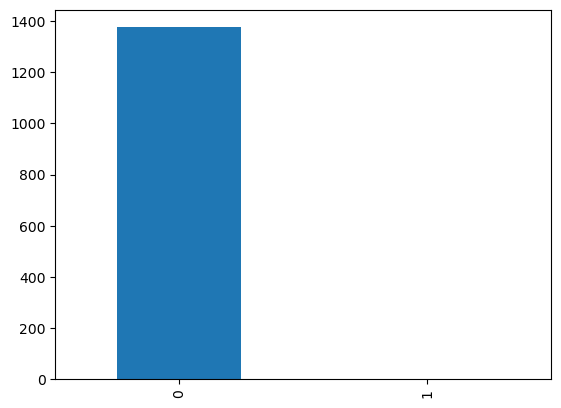

In [416]:
raw_data['generated'].value_counts().plot(kind='bar')

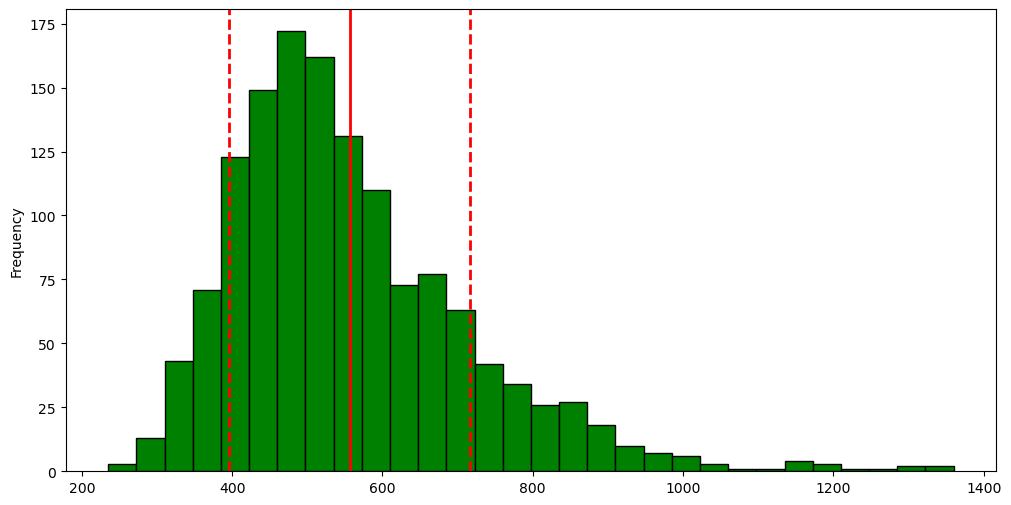

In [417]:
raw_data['text_len'].plot(kind='hist', bins=30, figsize=(12,6), edgecolor='black', linewidth=1.0, color='green')

plt.axvline(raw_data['text_len'].mean(), color='r', linestyle='solid', linewidth=2)
plt.axvline(raw_data['text_len'].mean() + raw_data['text_len'].std(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(raw_data['text_len'].mean()-raw_data['text_len'].std(), color='r', linestyle='dashed', linewidth=2)

In [418]:
combined_df = pd.concat([raw_data, generated_text_df], axis=0)
combined_df.reset_index(drop=True, inplace=True)

In [419]:
# Save the combined data to a csv file
combined_df.to_csv('../Data/Detect AI Generated Text/combined_essays.csv', index=False)

In [420]:
combined_df.groupby(['prompt_id', 'generated']).size()

prompt_id  generated
0          0            707
           1            716
1          0            668
           1            665
dtype: int64

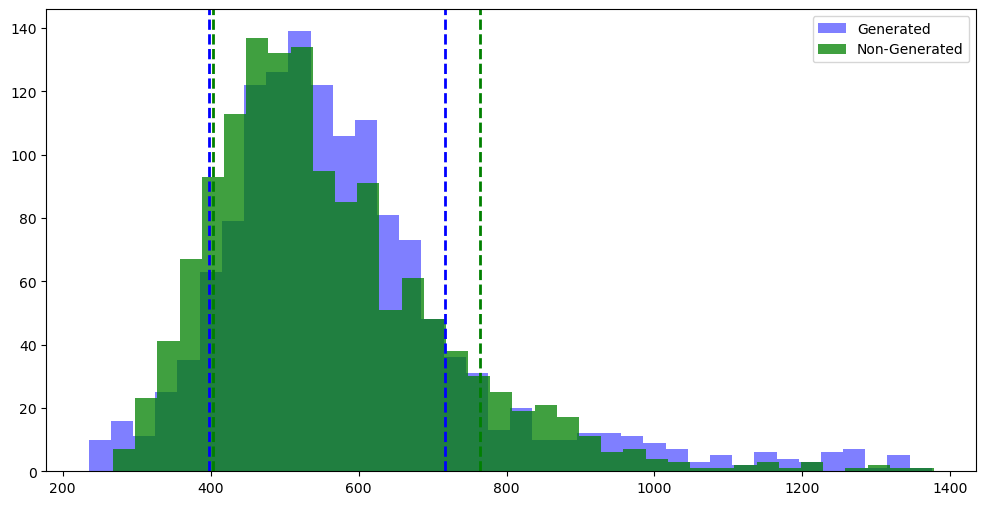

In [423]:
# Compare the text length distributions between generated and non-generated text
plt.figure(figsize=(12,6))
binwidth = 30
plt.hist(combined_df[combined_df['generated'] == 1]['text_len'], bins=range(min(combined_df[combined_df['generated'] == 1]['text_len']), max(combined_df[combined_df['generated'] == 1]['text_len']) + binwidth, binwidth),  alpha=0.5, label='Generated', color='blue')
plt.hist(combined_df[combined_df['generated'] == 0]['text_len'], bins=range(min(combined_df[combined_df['generated'] == 0]['text_len']), max(combined_df[combined_df['generated'] == 0]['text_len']) + binwidth, binwidth), alpha=0.75, label='Non-Generated', color='green')
plt.axvline(combined_df[combined_df['generated'] == 0]['text_len'].mean() + combined_df[combined_df['generated'] == 0]['text_len'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(combined_df[combined_df['generated'] == 1]['text_len'].mean() + combined_df[combined_df['generated'] == 1]['text_len'].std(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(combined_df[combined_df['generated'] == 0]['text_len'].mean()-combined_df[combined_df['generated'] == 0]['text_len'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(combined_df[combined_df['generated'] == 1]['text_len'].mean()-combined_df[combined_df['generated'] == 1]['text_len'].std(), color='green', linestyle='dashed', linewidth=2)
plt.legend()
plt.show()

In [345]:
# Pull text from the generated essays for prompt 0
prompt_0_generated = combined_df[(combined_df['prompt_id'] == 0) & (combined_df['generated'] == 1)]

# Pull text from the non-generated essays for prompt 0
prompt_0_non_generated = combined_df[(combined_df['prompt_id'] == 0) & (combined_df['generated'] == 0)]

# Pull text from the generated essays for prompt 1
prompt_1_generated = combined_df[(combined_df['prompt_id'] == 1) & (combined_df['generated'] == 1)]

# Pull text from the non-generated essays for prompt 1
prompt_1_non_generated = combined_df[(combined_df['prompt_id'] == 1) & (combined_df['generated'] == 0)]

# Word Clouds

In [346]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    essays = ""
    for i, row in data.iterrows():
        # Divide the source text into paragraphs by splitting on the string '\n\n'
        paragraphs = row['text'].splitlines()
        for paragraph in paragraphs:
            essays += " " + paragraph

    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords
    ).generate(essays)

    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

## Student Written for Prompt 0

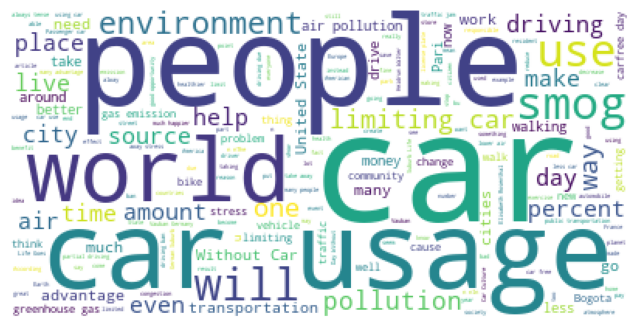

In [347]:
show_wordcloud(prompt_0_non_generated)

## AI Generated for Prompt 0

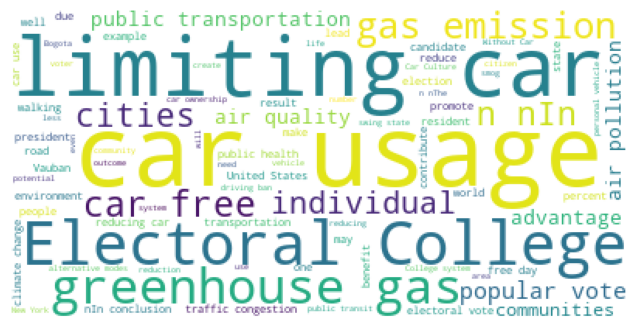

In [348]:
show_wordcloud(prompt_0_generated)

## Student Written for Prompt 1

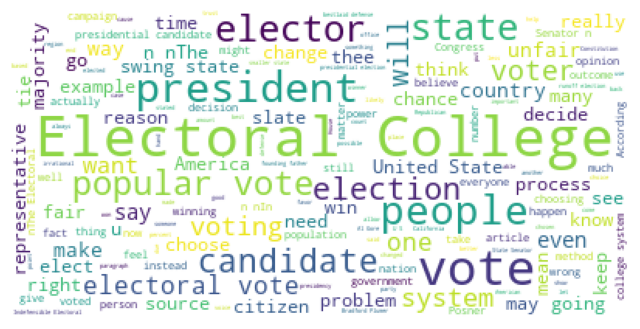

In [349]:
show_wordcloud(prompt_1_non_generated)

## AI Generated for Prompt 1

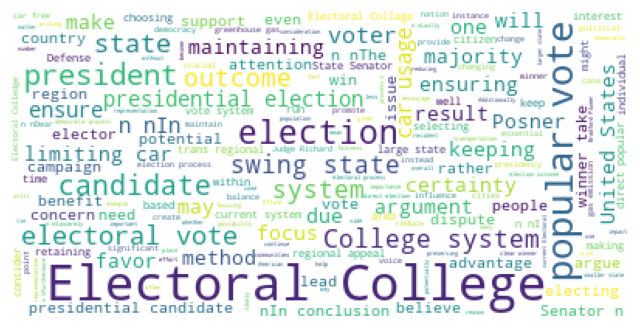

In [350]:
show_wordcloud(prompt_1_generated)

# N-Grams

In [351]:
# N-grams
from nltk import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

def get_ngrams(text, n):
    n_grams = ngrams(word_tokenize(text), n)
    return [' '.join(grams) for grams in n_grams]

def get_top_ngrams(corpus, n, k):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k]

## Prompt 0

### Unigrams for Student Written for Prompt 0


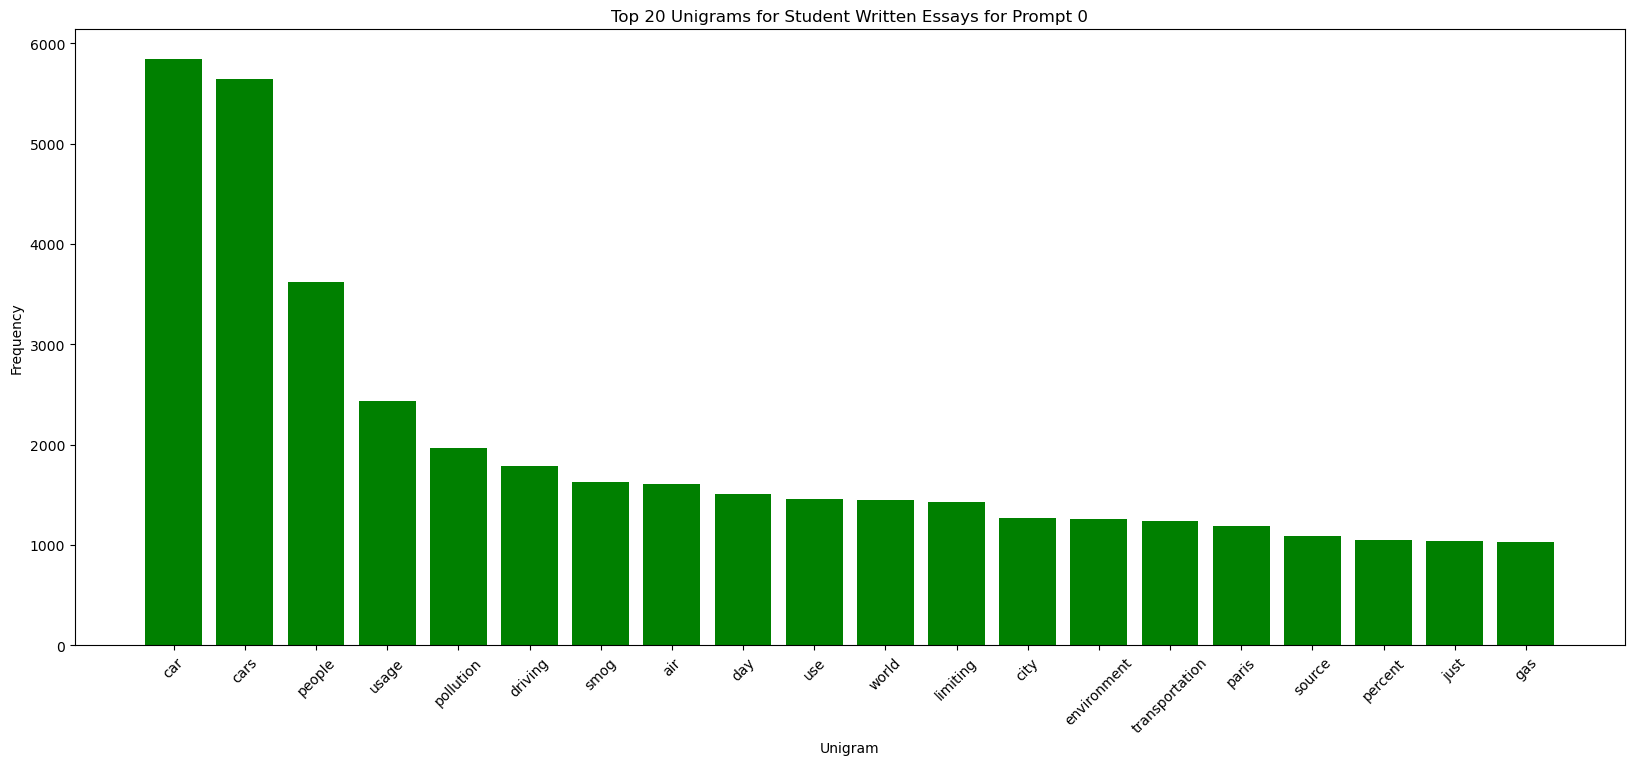

In [352]:
unigrams = get_top_ngrams(prompt_0_non_generated['text'], 1, 20)
unigrams = dict(unigrams)
plt.figure(figsize=(20,8))
plt.bar(unigrams.keys(), unigrams.values(), color='g')
plt.title('Top 20 Unigrams for Student Written Essays for Prompt 0')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Unigrams for AI Generated for Prompt 0

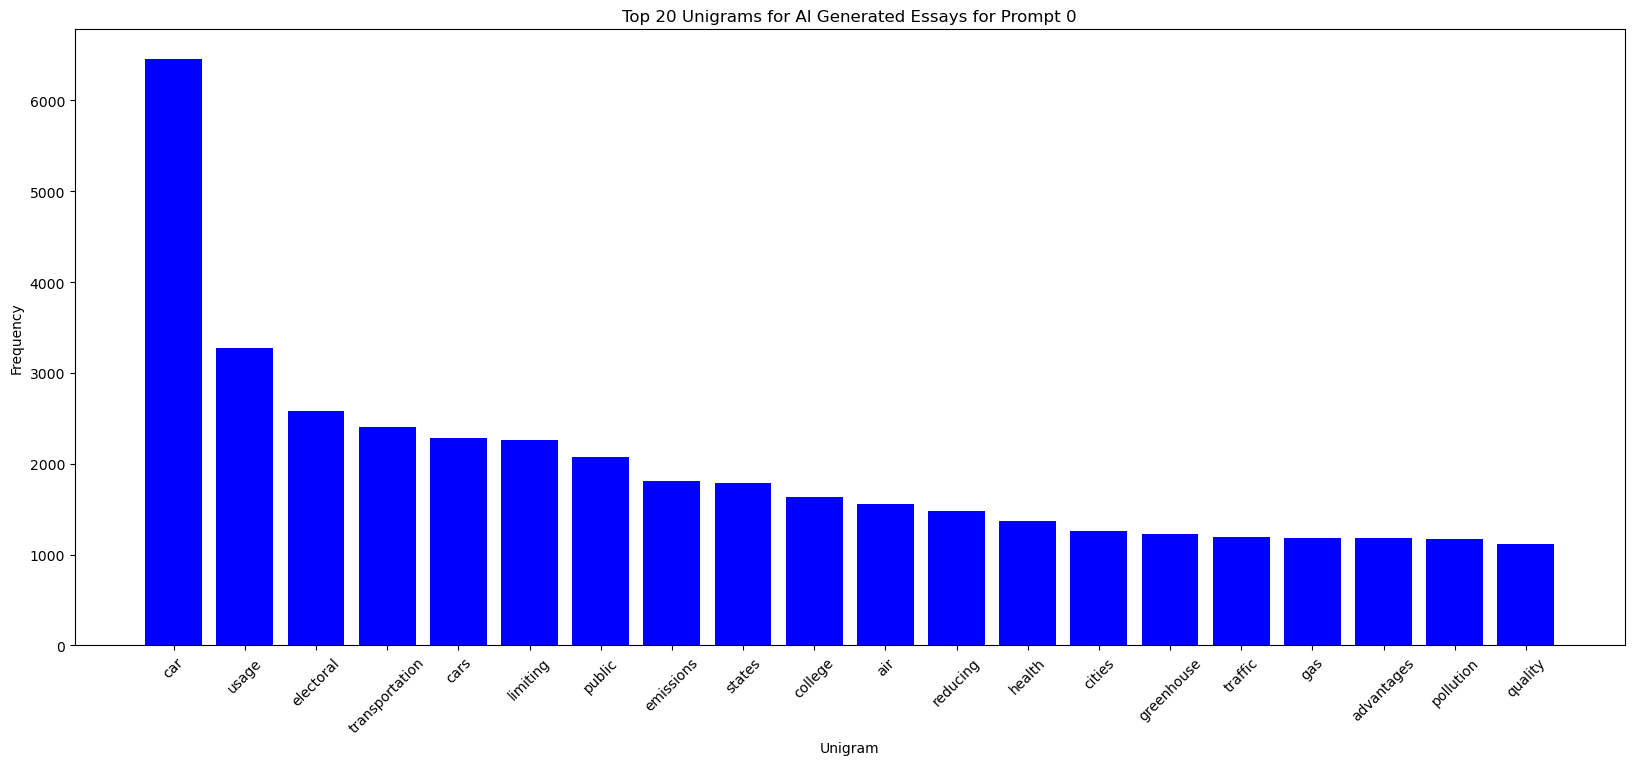

In [353]:
unigrams = get_top_ngrams(prompt_0_generated['text'], 1, 20)
unigrams = dict(unigrams)
plt.figure(figsize=(20,8))
plt.bar(unigrams.keys(), unigrams.values(), color='b')
plt.title('Top 20 Unigrams for AI Generated Essays for Prompt 0')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Unigrams Comparison

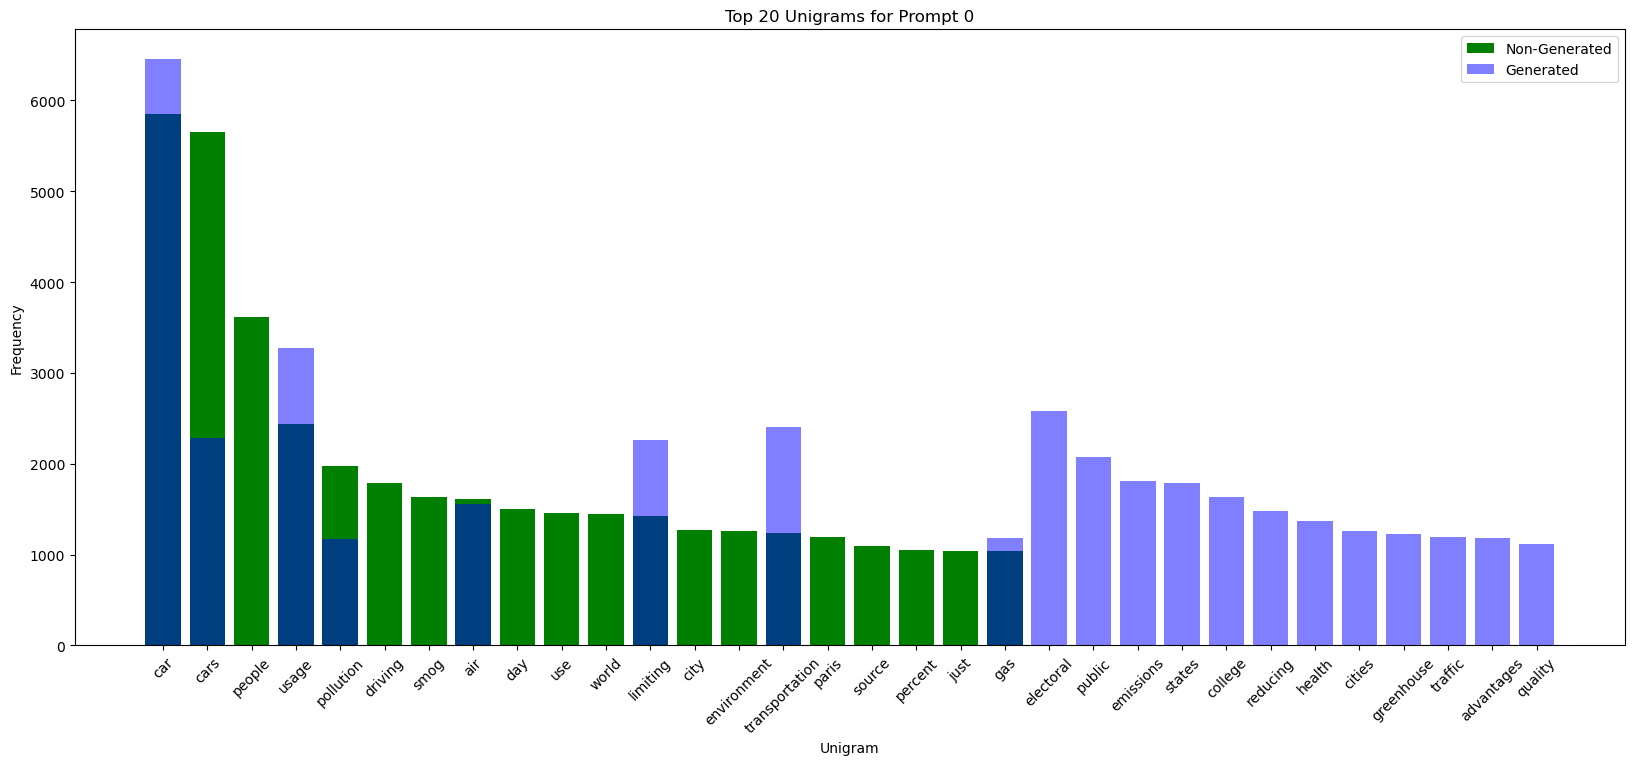

In [354]:
unigrams = get_top_ngrams(prompt_0_non_generated['text'], 1, 20)
unigrams = dict(unigrams)
unigrams_gen = get_top_ngrams(prompt_0_generated['text'], 1, 20)
unigrams_gen = dict(unigrams_gen)
plt.figure(figsize=(20,8))
plt.bar(unigrams.keys(), unigrams.values(), color='g')
plt.bar(unigrams_gen.keys(), unigrams_gen.values(), color='b', alpha=0.5)
plt.title('Top 20 Unigrams for Prompt 0')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(['Non-Generated', 'Generated'])
plt.show()

'Electoral' and 'college' provide evidence that some AI generated essays from prompt 1 are appearing under prompt 0. This may have been an error from the LLM or an error in how the essays were saved.

While this affects the EDA analysis, it will not affect the model training. Training is unrelated to the corresponding prompt.

### Trigrams for Student Written for Prompt 0

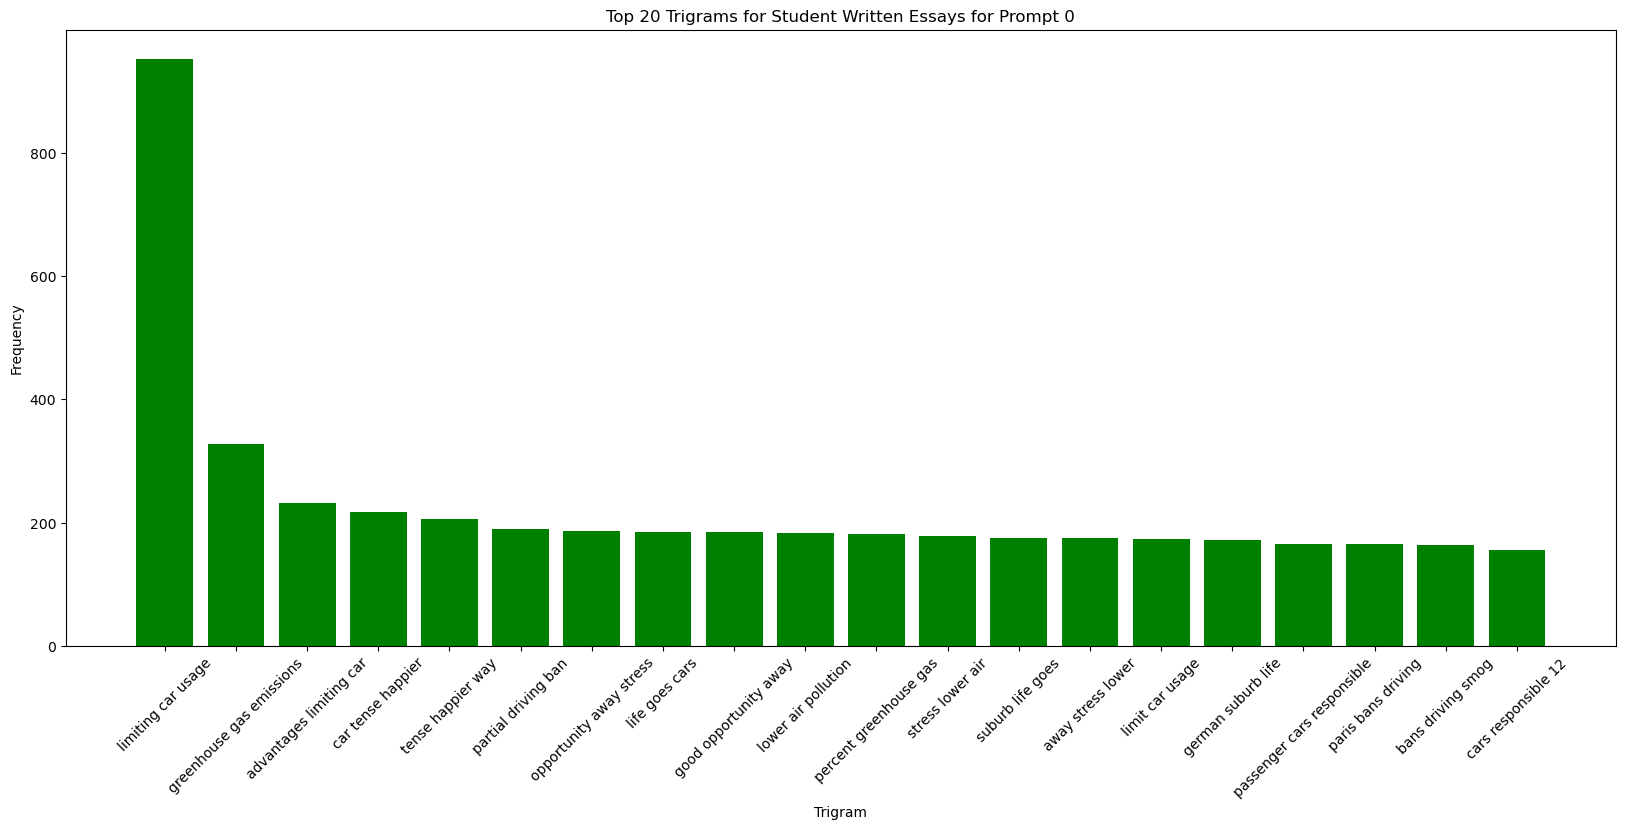

In [355]:
trigrams = get_top_ngrams(prompt_0_non_generated['text'], 3, 20)
trigrams = dict(trigrams)
plt.figure(figsize=(20,8))
plt.bar(trigrams.keys(), trigrams.values(), color='g')
plt.title('Top 20 Trigrams for Student Written Essays for Prompt 0')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Trigrams for AI Generated for Prompt 0

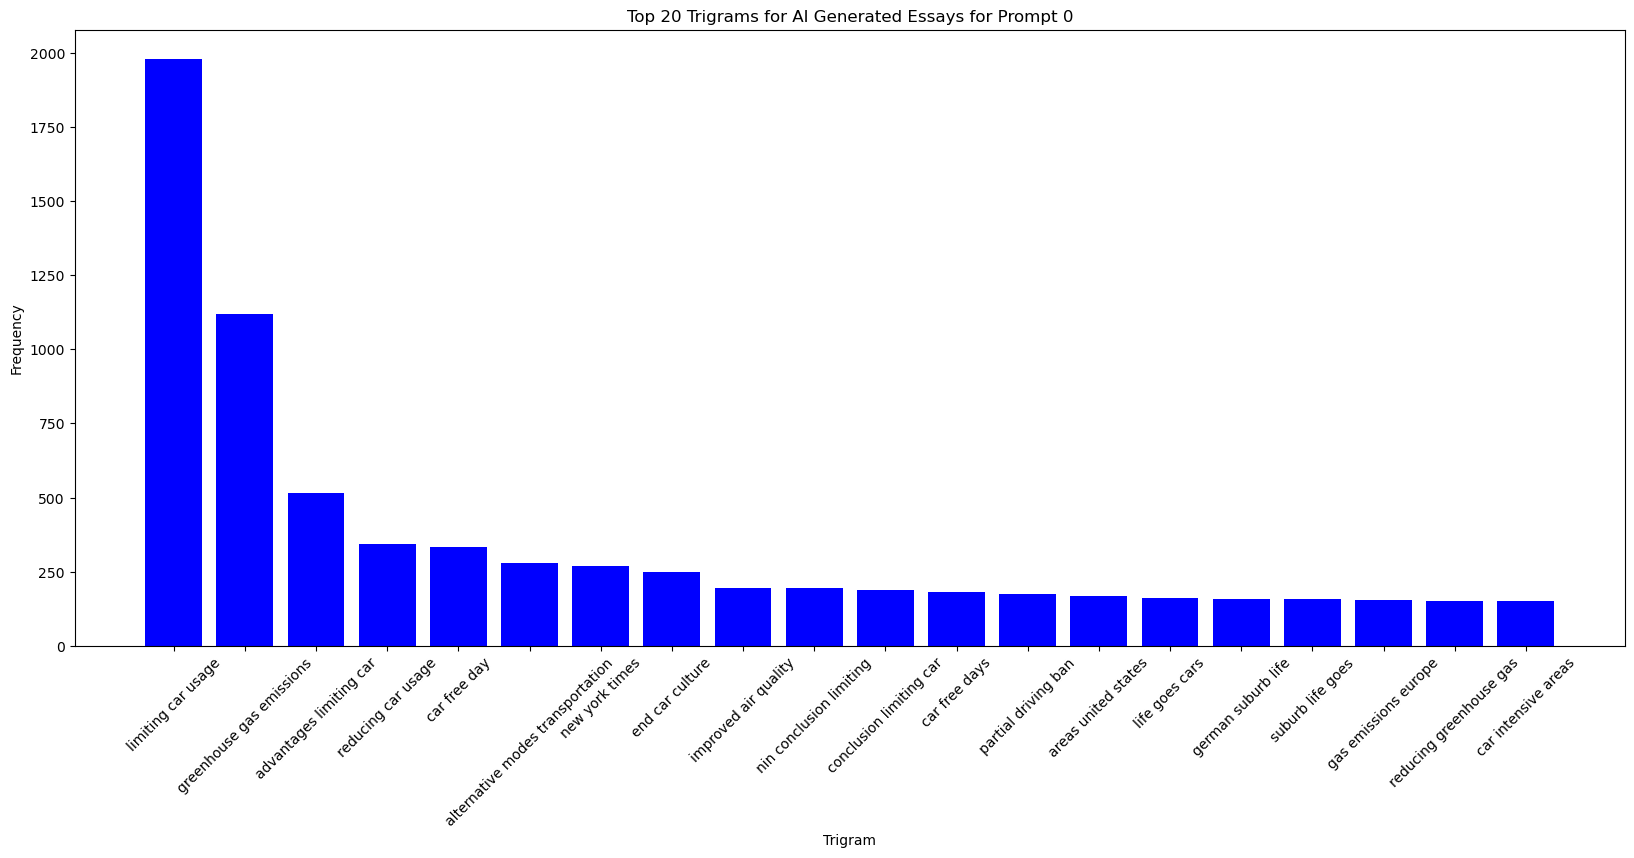

In [356]:
trigrams = get_top_ngrams(prompt_0_generated['text'], 3, 20)
trigrams = dict(trigrams)
plt.figure(figsize=(20,8))
plt.bar(trigrams.keys(), trigrams.values(), color='b')
plt.title('Top 20 Trigrams for AI Generated Essays for Prompt 0')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Trigrams Comparison for Prompt 0

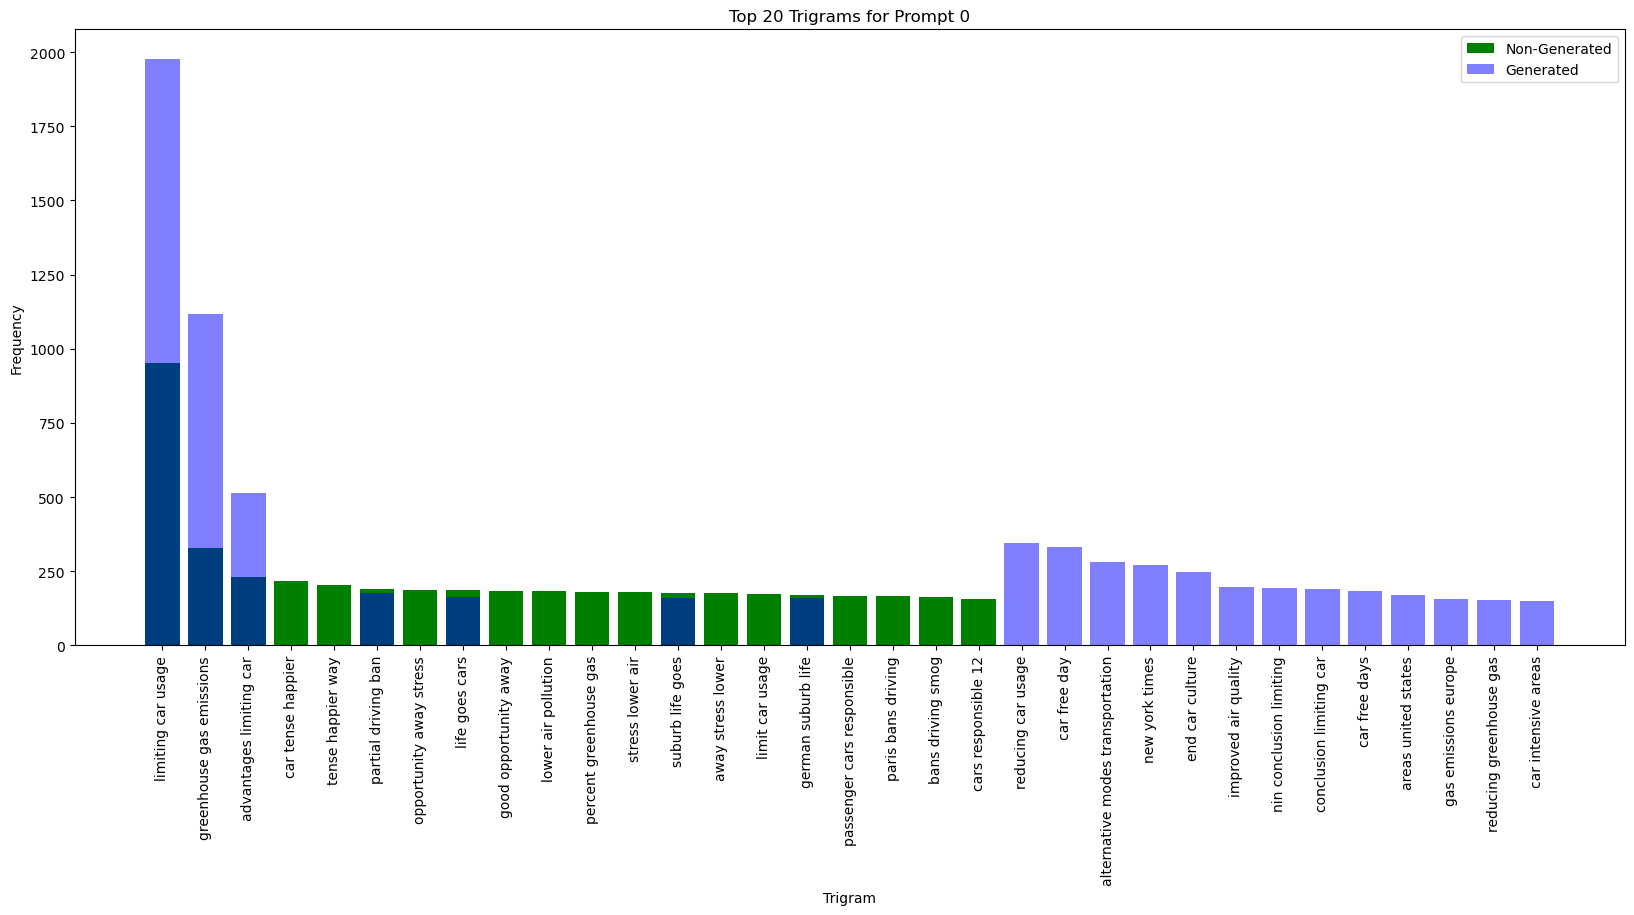

In [357]:
Trigrams = get_top_ngrams(prompt_0_non_generated['text'], 3, 20)
Trigrams = dict(Trigrams)
Trigrams_gen = get_top_ngrams(prompt_0_generated['text'], 3, 20)
Trigrams_gen = dict(Trigrams_gen)
plt.figure(figsize=(20,8))
plt.bar(Trigrams.keys(), Trigrams.values(), color='g')
plt.bar(Trigrams_gen.keys(), Trigrams_gen.values(), color='b', alpha=0.5)
plt.title('Top 20 Trigrams for Prompt 0')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.legend(['Non-Generated', 'Generated'])
plt.show()

## Prompt 1

### Unigrams for Student Written for Prompt 1

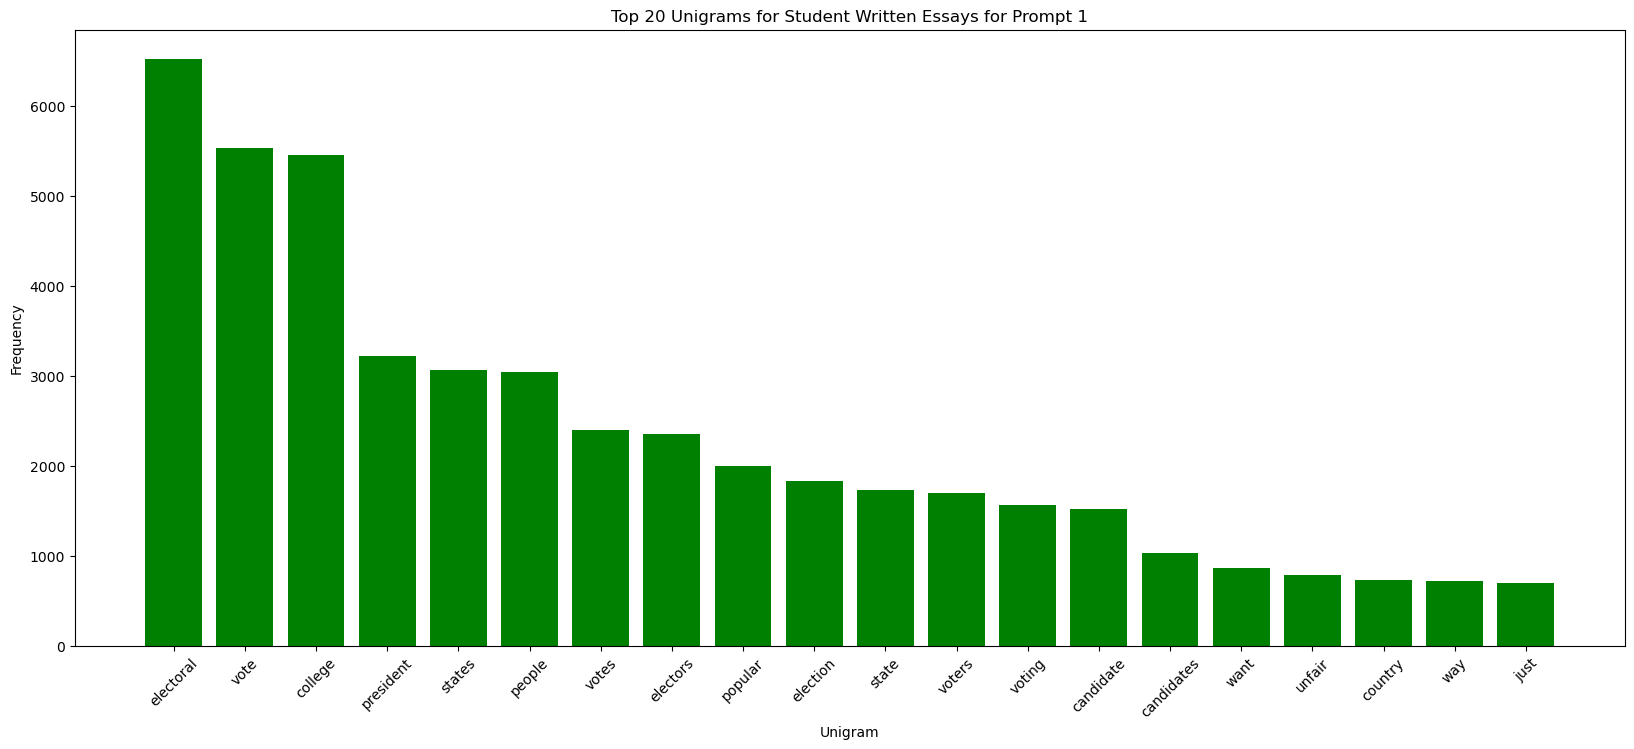

In [358]:
unigrams = get_top_ngrams(prompt_1_non_generated['text'], 1, 20)
unigrams = dict(unigrams)
plt.figure(figsize=(20,8))
plt.bar(unigrams.keys(), unigrams.values(), color='g')
plt.title('Top 20 Unigrams for Student Written Essays for Prompt 1')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Unigrams for AI Generated for Prompt 1

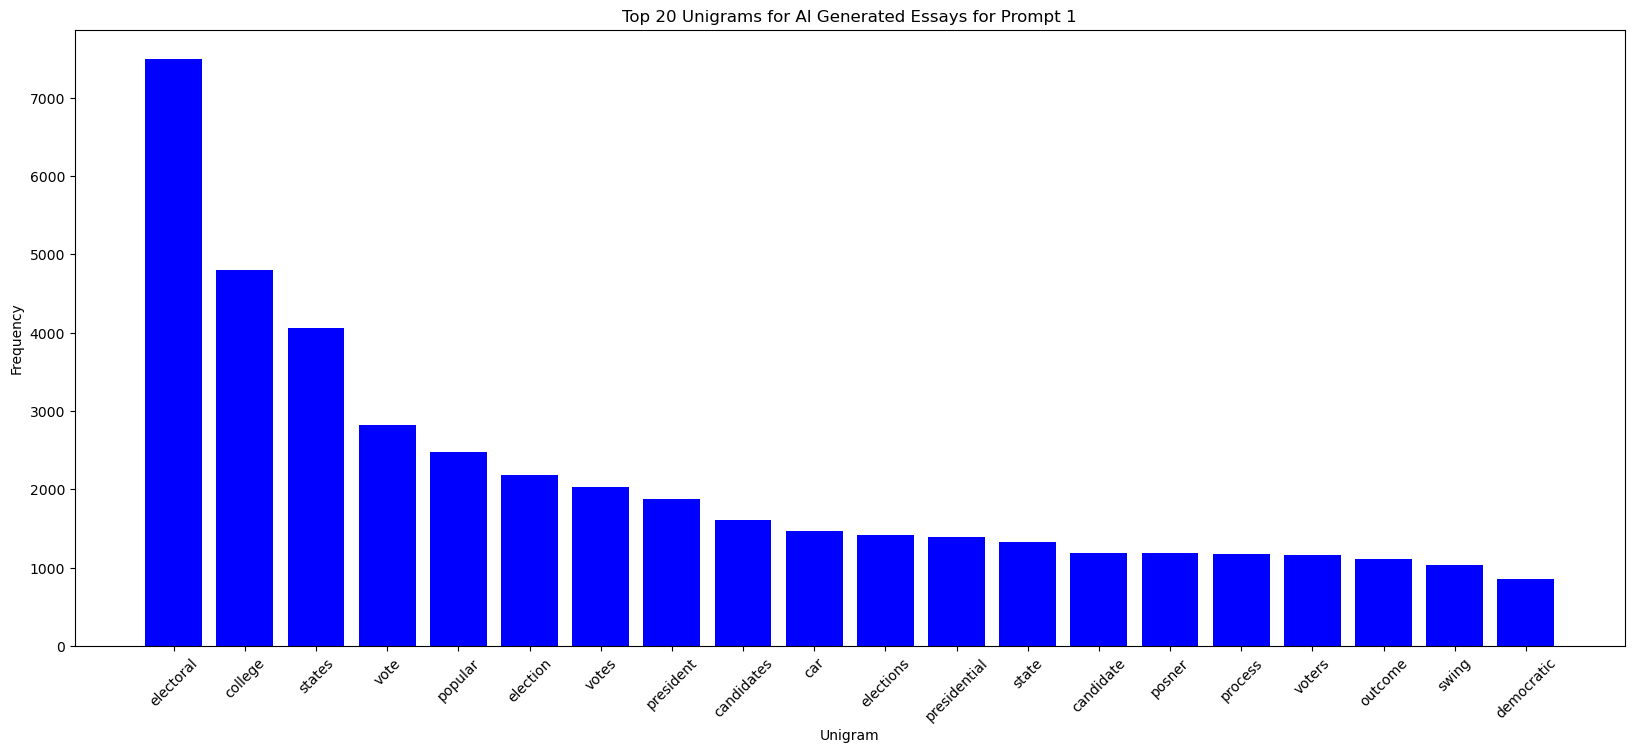

In [359]:
unigrams = get_top_ngrams(prompt_1_generated['text'], 1, 20)
unigrams = dict(unigrams)
plt.figure(figsize=(20,8))
plt.bar(unigrams.keys(), unigrams.values(), color='b')
plt.title('Top 20 Unigrams for AI Generated Essays for Prompt 1')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Unigrams Comparison for Prompt 1

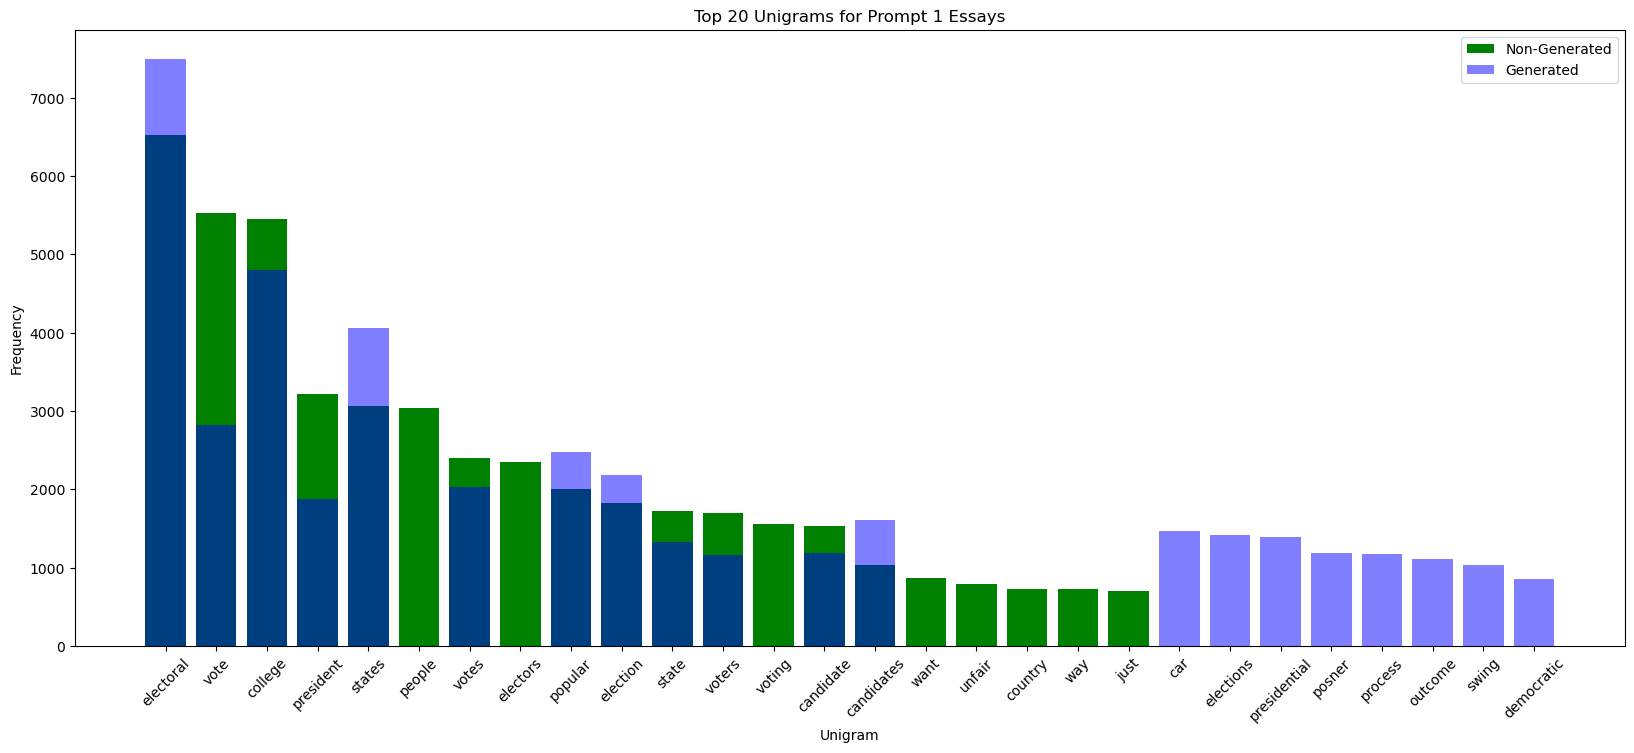

In [360]:
unigrams = get_top_ngrams(prompt_1_non_generated['text'], 1, 20)
unigrams = dict(unigrams)
unigrams_gen = get_top_ngrams(prompt_1_generated['text'], 1, 20)
unigrams_gen = dict(unigrams_gen)
plt.figure(figsize=(20,8))
plt.bar(unigrams.keys(), unigrams.values(), color='g')
plt.bar(unigrams_gen.keys(), unigrams_gen.values(), color='b', alpha=0.5)
plt.title('Top 20 Unigrams for Prompt 1 Essays')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(['Non-Generated', 'Generated'])
plt.show()

### Trigrams for Student Written for Prompt 1

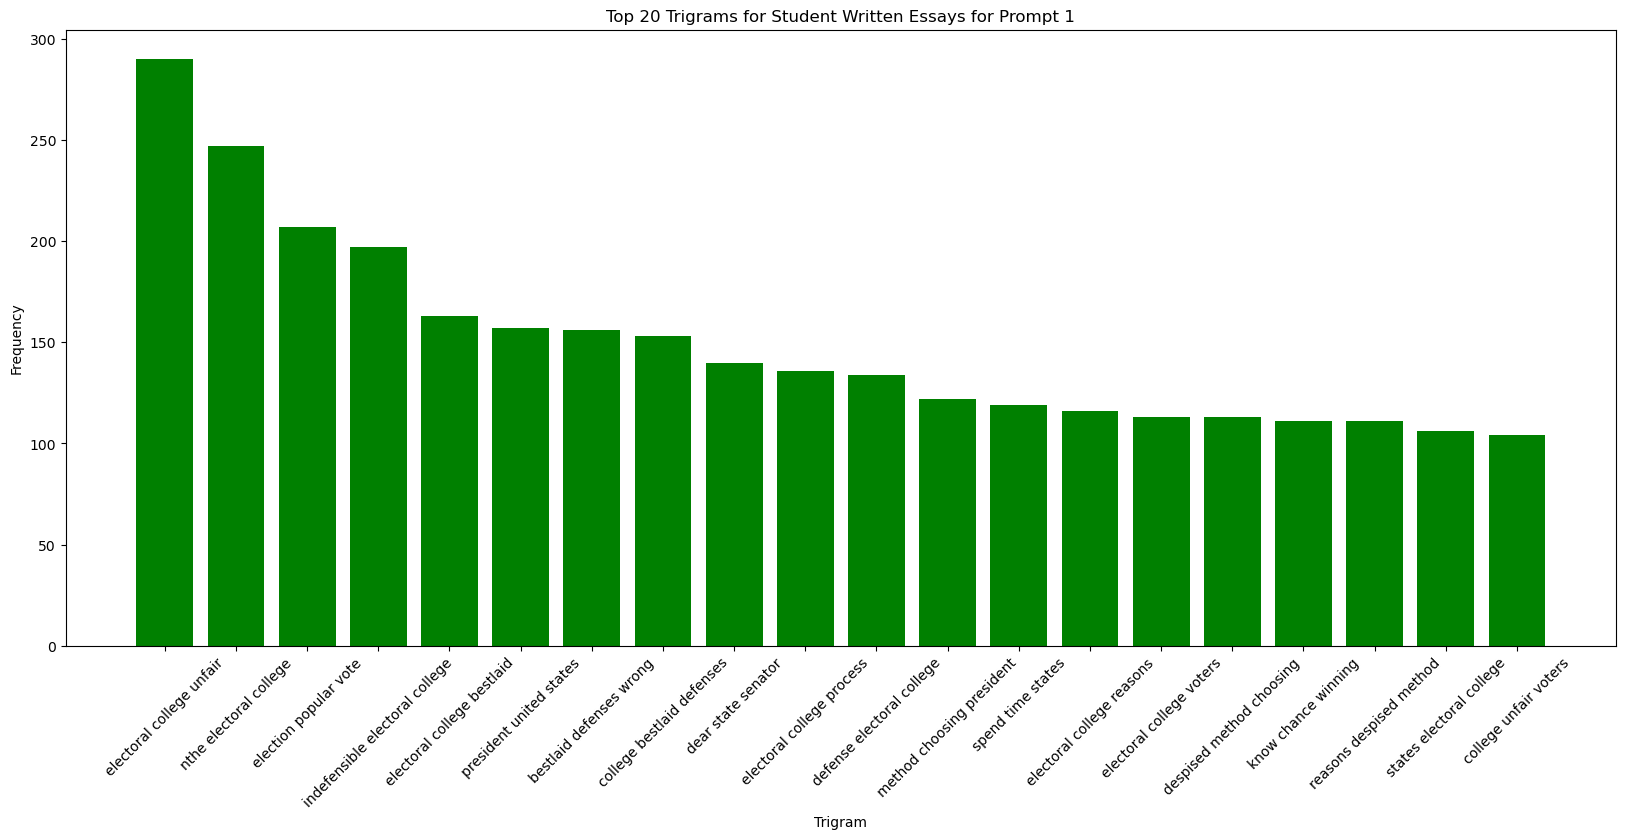

In [361]:
trigrams = get_top_ngrams(prompt_1_non_generated['text'], 3, 20)
trigrams = dict(trigrams)
plt.figure(figsize=(20,8))
plt.bar(trigrams.keys(), trigrams.values(), color='g')
plt.title('Top 20 Trigrams for Student Written Essays for Prompt 1')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Trigrams for AI Generated for Prompt 1

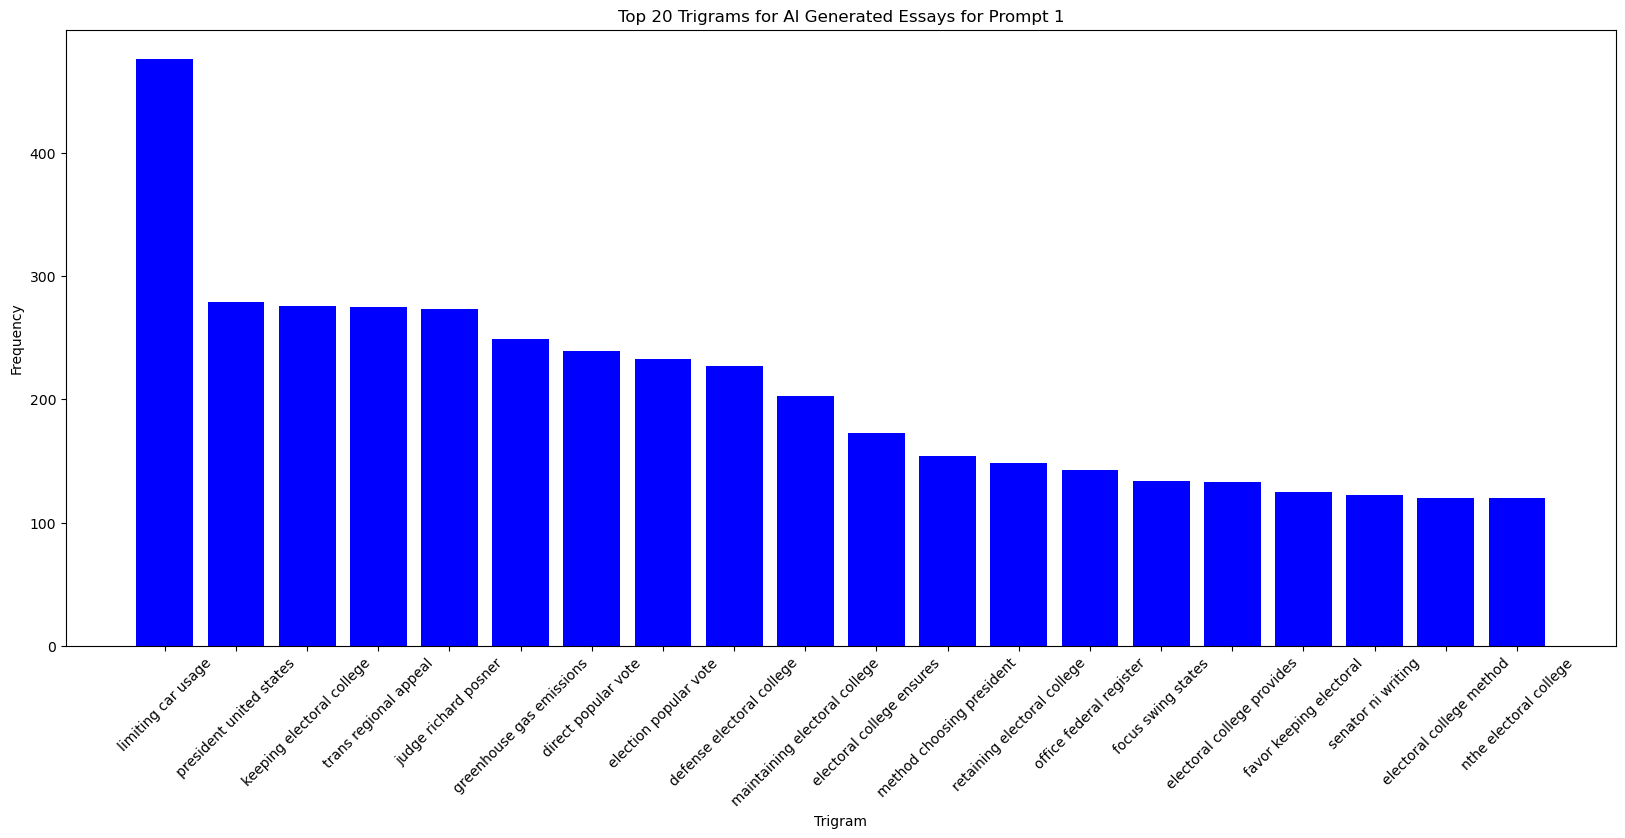

In [362]:
trigrams = get_top_ngrams(prompt_1_generated['text'], 3, 20)
trigrams = dict(trigrams)
plt.figure(figsize=(20,8))
plt.bar(trigrams.keys(), trigrams.values(), color='b')
plt.title('Top 20 Trigrams for AI Generated Essays for Prompt 1')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

After 'electoral' and 'college' appearing earlier, the trigram 'limiting car usage' for AI generated essays for prompt 1 provides evidence that is was most like an error is saving the essays, and not from one of the LLMs. 

### Trigrams Comparison for Prompt 1

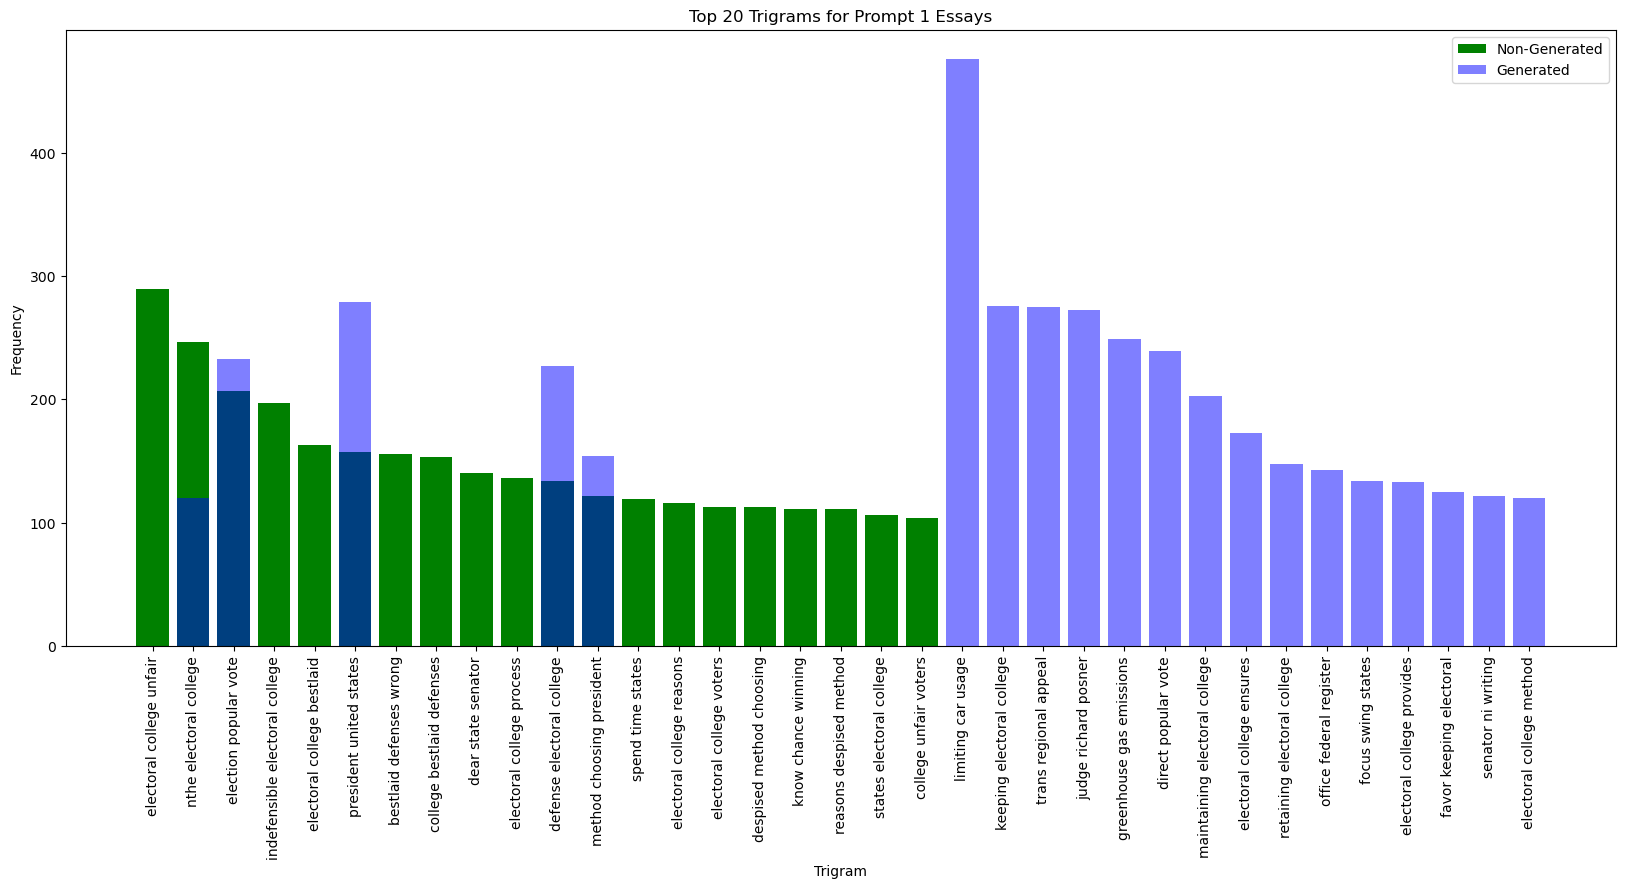

In [363]:
Trigrams = get_top_ngrams(prompt_1_non_generated['text'], 3, 20)
Trigrams = dict(Trigrams)
Trigrams_gen = get_top_ngrams(prompt_1_generated['text'], 3, 20)
Trigrams_gen = dict(Trigrams_gen)
plt.figure(figsize=(20,8))
plt.bar(Trigrams.keys(), Trigrams.values(), color='g')
plt.bar(Trigrams_gen.keys(), Trigrams_gen.values(), color='b', alpha=0.5)
plt.title('Top 20 Trigrams for Prompt 1 Essays')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.legend(['Non-Generated', 'Generated'])
plt.show()

Excluding the error with 'limiting car usage', there is not a lot of overlap of the remaining trigrams. This provided potential in identifying phrases used between students compared to AI, which could lead to success in AI detection.